# Topic Models

In [65]:
import pandas as pd

In [66]:
df = pd.read_excel('../data/reviews.xlsx', encoding='utf8')
len(df)

434292

In [67]:
df.head()

,category,text,clean_text
0,Beauty and Wellness,there was an issue with the delivery but this ...,issue delivery resolve quickly complete care s...
1,Computer & Accessories,i found the item i was looking for quickly on ...,find item look quickly web site place order to...
2,Bathroom,part ordered monday pm and received it next day .,order monday pm receive day
3,Cell phone Recycling,the day the phone was received i had the money...,day phone receive money bank
4,Flowers,"flowers were beautiful , delivered on time and...",flower beautiful deliver time notify progress ...


In [68]:
print(len(df))
df = df[df['clean_text'].notnull()]
print(len(df))

434292
434207


## LDA

In [69]:
from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary
import time # to know how long training took
import multiprocessing # to speed things up by parallelizing

In [70]:
# get dictionary
instances = df.clean_text.apply(str.split)[:50000]
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.1)
print(dictionary, flush=True)

creating dictionary
Dictionary(857 unique tokens: ['care', 'complete', 'issue', 'quickly', 'resolve']...)


In [75]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

num_topics = 10

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     model_corpus, # what to train on 
                     id2word=dictionary, # mappinf from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size # update after this many instances
                    )
    
print("done in {}".format(time.time()-start), flush=True)


translating corpus to IDs
tf-idf transformation
2500.0
fitting model
done in 56.70362901687622


In [76]:
import re

# transform the data into topic distros
topic_corpus = model[model_corpus]

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "flower", "beautiful", "keep", "friend", "inform"
2 "fast", "communication", "thank", "excellent", "start"
3 "vet", "viovet", "dog", "anim", "direct"
4 "memory", "battery", "work", "laptop", "need"
5 "helpful", "staff", "friendly", "ask", "customer"
6 "tyre", "fit", "fitting", "fitter", "car"
7 "money", "mazuma", "post", "account", "bank"
8 "product", "site", "item", "excellent", "website"
9 "buy", "product", "cheap", "shop", "look"
10 "value", "hassle", "simple", "money", "excellent"


## Aggregating topics by a dependent variable

In [85]:
# get a list of all the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(50000)]
# turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
# add the review category of each document (so we can aggregate)
topic_distros['category'] = df.category[:50000]

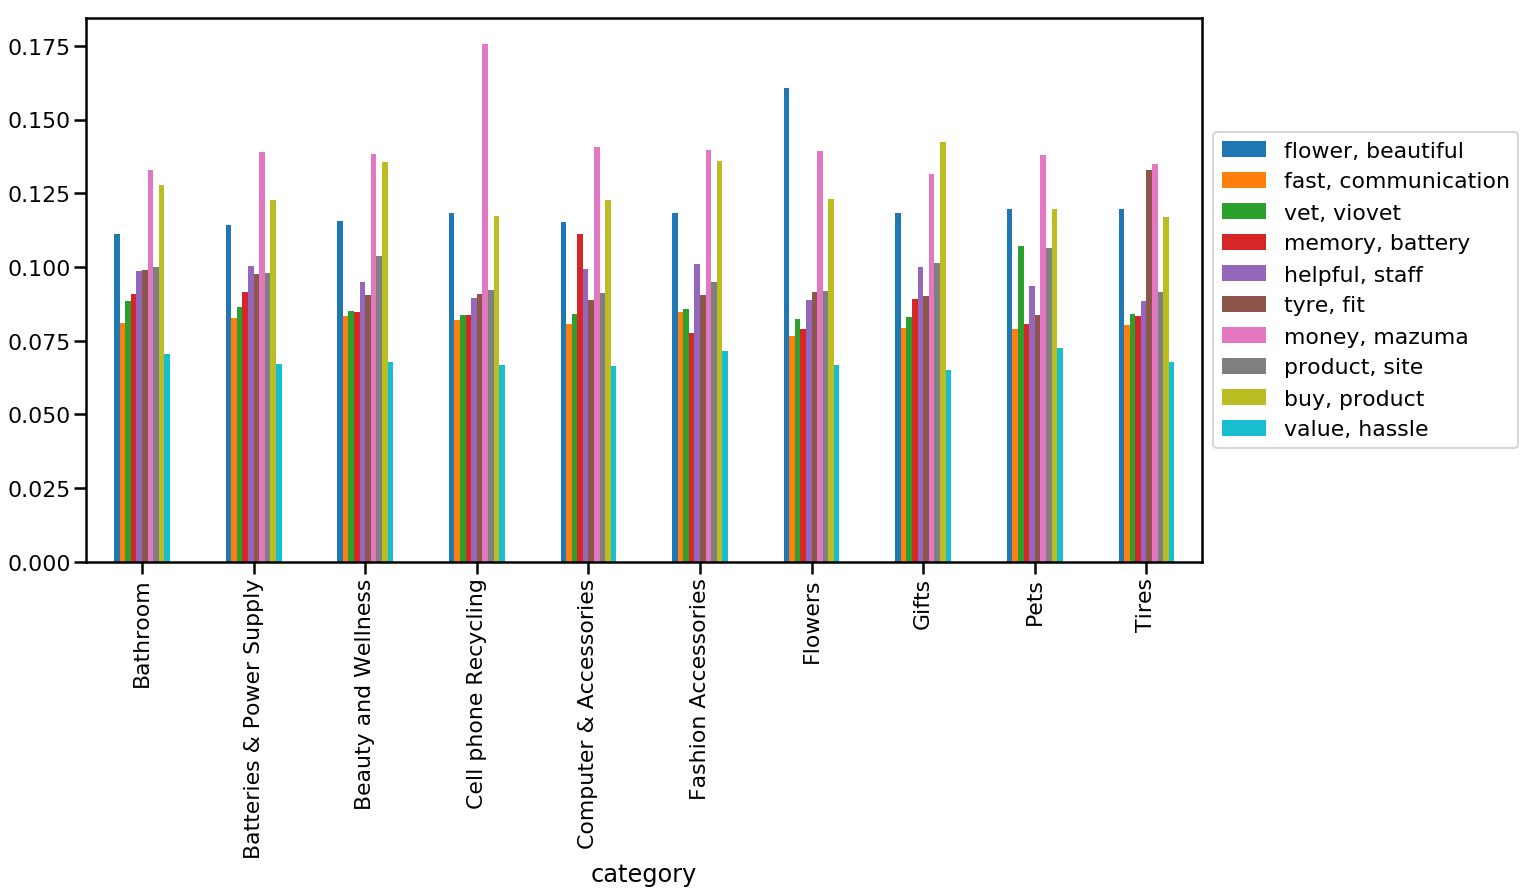

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt # make graphs
import seaborn # make prettier graphs

seaborn.set_context('poster') # use large font

fig, ax = plt.subplots(figsize=(20, 10)) # set graph size
# aggregate topics by review categories
aggregate_by_category = topic_distros.groupby(topic_distros.category).mean()
# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);
# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

# Guided LDA

In [99]:
import numpy as np
import guidedlda
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vectorize input
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2), min_df=20, max_df=0.1, stop_words='english')
X = vectorizer.fit_transform(df.clean_text.tolist())

# store lookup structures for convenience
vocab = vectorizer.get_feature_names()
word2id = dict((v, idx) for idx, v in enumerate(vocab))

print(X.shape)

In [100]:
# define topic seeds based on intuition
indicators = {
    'BATH': "bath,toilet,soap".split(','),
    'POWER': "battery,bank,plug".split(','), 
    'BEAUTY': "product,powder,cream".split(','),
    'PHONES': "phone,charger".split(','),
    'COMPUTER': "screen,keyboard,mouse".split(','),
    'FASHION': "trousers,shirt,skirt".split(','),
    'FLOWERS': "flower,color,smell,fresh".split(','),
    'GIFTS': "gift,present,give".split(','),
    'PETS': "dog,cat,leash,collar".split(','),
    'TIRES': "tire,tyre,wheel,car".split(',')
}

topic_names, seed_topic_list = zip(*indicators.items())
# filter out all words not actually in vocab
seed_topic_list = [[w for w in words if w in set(vocab)] for words in seed_topic_list]
    
# create a mapping {word_id: k}, which we need for the model
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id
        
print(seed_topic_list)

[['bath', 'toilet', 'soap'], ['battery', 'bank', 'plug'], ['product', 'powder', 'cream'], ['charger'], ['screen', 'keyboard', 'mouse'], ['shirt', 'skirt'], ['flower', 'color', 'smell', 'fresh'], ['gift', 'present'], ['dog', 'cat', 'collar'], ['tire', 'tyre', 'wheel', 'car']]


In [ ]:
# define model
model = guidedlda.GuidedLDA(n_topics=len(seed_topic_list), n_iter=100, random_state=7, refresh=50, alpha=0.5, eta=0.000001)

# fit the model with seeds
doc_topic = model.fit_transform(X, seed_topics=seed_topics, seed_confidence=10)

# retrieve the word descriptors
n_top_words = 5
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: "{}"'.format(topic_order[i], '" "'.join(topic_words)))

INFO:guidedlda:n_documents: 434207
INFO:guidedlda:vocab_size: 43266
INFO:guidedlda:n_words: 8652485
INFO:guidedlda:n_topics: 10
INFO:guidedlda:n_iter: 100
